# FEM Reference Implementation - 1

This notebook introduces a compact Fortran reference implementation of the **finite element method for the Poisson equation on the unit square**. The code is designed to provide a compact overview of the fundamental structure of a FEM implementation, including mesh generation, assembly, the solution procedure, and I/O operations. It allows users to experiment with the implementation and to visualize the resulting outputs directly within this notebook.


### Strong Formulation of the Poisson Problem:
Find $u: \Omega \rightarrow \mathbb{R}$ such that
$$
- \Delta u = f \quad \text{in } \Omega = [0,1] \times [0,1]
$$
with homogeneous Dirichlet boundary conditions:
$$
u = 0 \quad \text{on } \partial \Omega.
$$

Implemented with the source term:
$$
f(x,y) = \sqrt{x \, y^{2}} \, \sin(\pi x) \, \cos(-\pi y).
$$


### Key characteristics:
- **Bilinear quadrilateral (Q1)** elements on a structured mesh.
- The numerical integration of the element matrices is conducted using Gauss quadrature.
- Homogeneous Dirichlet boundary conditions on the domain boundary (u = 0).
- Iterative solution using a basic Conjugate Gradient (CG) solver.

### File Structure
```
FEM_Reference_Implementation_1/
│
├─ README.txt
│
├─ data/
│   ├─ matrix/
│   ├─ mesh/
│   └─ solution/
│
├─ src/
│   ├─ main.f90
│   ├─ mod_assemble.f90
│   ├─ mod_io.f90
│   ├─ mod_mesh.f90
│   ├─ mod_rhs.f90
│   └─ mod_solver.f90
│
├─ scripts/
│   ├─ clean_src.sh
│   └─ compile_and_run.sh
│
├─ jupyter_notebook.ipynb
```



# Compile and Execute Instructions for the Fortran FEM Implementation

The repository includes two helper scripts in the `scripts/` directory to simplify building and cleaning the Fortran implementation:
- `compile_fortran.sh`  
  - Compiles the Fortran sources located in the `src/` directory and produces the executable `main`.  
- `clean_src.sh`  
  - Removes build artifacts created by the compilation process (common patterns: `main`, `*.o`, `*.mod`, backup files like `*.mod~`) from the `src/` directory.  
  - Can be used to clean up the source directory before recompiling or to free up space.
  - Supports a non‑interactive mode: pass `--yes` or `-y` to remove artifacts without prompting for confirmation.

**Make the scripts executable (run once)**
```bash
chmod +x scripts/compile_fortran.sh scripts/clean_src.sh
```

**Compile the Fortran code**
```bash
./scripts/compile_fortran.sh
```

Alternative: compile manually from `src/` (equivalent command)
```bash
cd src
gfortran -O2 -std=f2008 mod_mesh.f90 mod_assemble.f90 mod_rhs.f90 mod_solver.f90 mod_io.f90 main.f90 -o main
```

**Clean build artifacts**
```bash
./scripts/clean_src.sh        # The script will list the detected artifacts and ask for confirmation before removing them.
# Alternative: 
./scripts/clean_src.sh --yes  # The script will remove artifacts without prompting for confirmation.
```

**Run the compiled program**
```bash
# From the project root:
./src/main
```



# Quick Overview of the FEM Implementation
This section provides a concise description of the modules and key subroutines in the reference FEM implementation.

**`main.f90`:**
- Primary driver program that orchestrates the FEM workflow: mesh generation → assembly → solver → output.
- Configurable parameters for exercises:
  - `nx`, `ny`: mesh resolution (number of nodes in x/y directions).
  - `tol`: convergence tolerance for the CG solver.
  - `maxit`: maximum number of CG iterations.

**`mod_mesh.f90` (`build_quad_mesh`):**
- Constructs a structured Q1 quadrilateral mesh on the unit square [0,1] × [0,1].
- Produces nodal coordinates and element connectivity for an `nx × ny` node grid.
- Element node ordering: lower-left → lower-right → upper-right → upper-left (counterclockwise).

**`mod_assemble.f90` (`assemble_poisson_quad`):**
- Computes local element stiffness matrices and element load vectors, then assembles the global stiffness matrix `A` and RHS vector `f` for the Poisson problem.
- Uses bilinear (Q1) shape functions and 2×2 Gauss quadrature per element for numerical integration.
- Applies homogeneous Dirichlet boundary conditions (u = 0) on the domain boundary.

**`mod_rhs.f90` (`src_const`):**
- Provides the source term f(x,y) (rhs: right‑hand side) used by the Poisson equation assembly.
  - $ f(x,y) = \sqrt{x \, y^{2}} \, \sin(\pi x) \, \cos(-\pi y) $

**`mod_solver.f90` (`cg_solver`):**
- Solves the linear system $A u = f$ using the Conjugate Gradient (CG) method.

**`mod_io.f90` -> I/O routines (`write_mesh_csv`, `write_mesh_vtk`, `write_A_matrix_market`, `write_solution_csv`, `write_solution_vtk`):**
- Manages writing mesh, matrix and solution data to disk for visualization and analysis.
- Key outputs:
    - `data/mesh/nodes.csv`
    - `data/mesh/elements.csv`
    - `data/mesh/mesh.vtk`
    - `data/matrix/A.mtx`
    - `data/solution/solution.csv`
    - `data/solution/solution.vtk`
<p style="margin-top:120px;"></p>



---
# Analysis and Visualization of the FEM Implementation

In [2]:
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import pandas as pd

## Content of the Generated CSV Files

The Fortran implementation produces three CSV files containing the mesh data (nodes and elements) as well as the computed nodal solution values:
- `nodes.csv`
- `elements.csv`
- `solution.csv` 
A brief description of each file is provided below. The indexing of nodes and elements, as well as the node ordering within each element, can be easily verified for a small mesh (e.g., 3×3 nodes → 2×2 elements). The functions listed below allow visual inspection of the mesh, particularly when enabling the option `show_node_ids=True`.
    

**`nodes.csv` — Node List**
- provides the coordinates of the mesh nodes.

| `idx` | `x` | `y` |
|---|---|---|
| Node index (1-based) | x-coordinate | y-coordinate |


**`elements.csv` — Element Connectivity (Quadrilateral Elements)**
- provides the mapping of nodes to elements (node-element incidence).
- Node ordering for each element is lower-left → lower-right → upper-right → upper-left (counterclockwise). 

| `element_id` | `n1` | `n2` | `n3` | `n4` |
|---|---|---|---|---|
| Element index (1-based) | Node lower-left of the element   | Node lower-right of the element   | Node upper-right of the element | Node upper-left of the element   |


**`solution.csv` — Nodal Values (Scalar Solution)**
- contains the computed nodal values (e.g., potential/temperature) at the mesh nodes.

| `idx` | `u` |
|---|---|
| Node index (1-based) | Solution at the node (e.g., potential / temperature) |

In [3]:
# Header of the nodes.csv file
pd.read_csv("data/mesh/nodes.csv").head()

,idx,x,y
0,1,0.000000,0.0
1,2,0.016949,0.0
2,3,0.033898,0.0
3,4,0.050847,0.0
4,5,0.067797,0.0


In [4]:
# Header of the elements.csv file
pd.read_csv("data/mesh/elements.csv").head()

,idx,n1,n2,n3,n4
0,1,1,2,62,61
1,2,2,3,63,62
2,3,3,4,64,63
3,4,4,5,65,64
4,5,5,6,66,65


In [5]:
# Header of the solution.csv file
pd.read_csv("data/solution/solution.csv").head() 

,idx,u
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


## Visualization of the Created Mesh

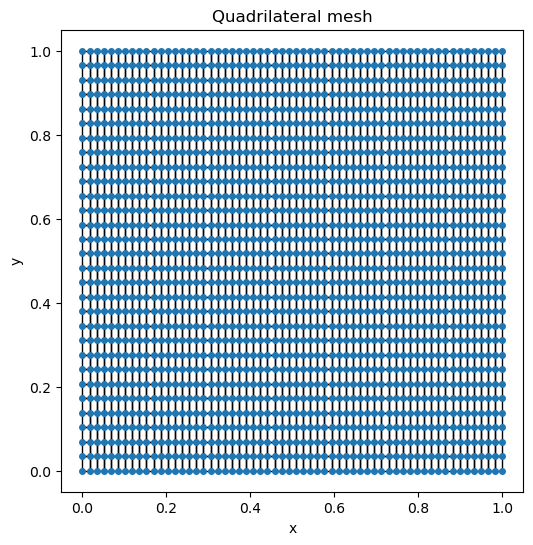

In [3]:
# Define paths to data files
nodes_file = 'data/mesh/nodes.csv'
elems_file = 'data/mesh/elements.csv'


def read_nodes(nodes_file):
    # skip header, expect: idx,x,y
    data = np.loadtxt(nodes_file, delimiter=',', skiprows=1)
    # index in first column, coordinates next two columns
    idx = data[:,0].astype(int)
    x = data[:,1]
    y = data[:,2]
    # build arrays indexed 1..nnode
    nnode = idx.max()
    X = np.empty(nnode+1)
    Y = np.empty(nnode+1)
    X.fill(np.nan); Y.fill(np.nan)
    X[idx] = x
    Y[idx] = y
    return X, Y

def read_elems(elems_file):
    # skip header, expect: idx,n1,n2,n3,n4
    data = np.loadtxt(elems_file, delimiter=',', skiprows=1).astype(int)
    # connectivity in columns
    conn = data[:,1:5]
    return conn

def plot_mesh(nodes_file, elems_file, show_node_ids):
    X, Y = read_nodes(nodes_file)
    conn = read_elems(elems_file)

    patches = []
    for el in conn:
        # el contains node indices (1-based). Build polygon with those coords.
        coords = [(X[n], Y[n]) for n in el]
        patches.append(Polygon(coords, closed=True, fill=False))

    fig, ax = plt.subplots(figsize=(6,6))
    pc = PatchCollection(patches, match_original=True)
    ax.add_collection(pc)

    # plot nodes
    ax.plot(X[1:], Y[1:], marker='o', linestyle='None', markersize=4)
    if show_node_ids:
        for i in range(1, X.size):
            ax.text(X[i], Y[i], str(i), fontsize=8, ha='center', va='center')

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Quadrilateral mesh')
    ax.autoscale()
    plt.show()


# Plot the mesh
plot_mesh(nodes_file=nodes_file, elems_file=elems_file, show_node_ids=False)



## Visualization of the Global Stiffness Matrix A

(1800, 1800)


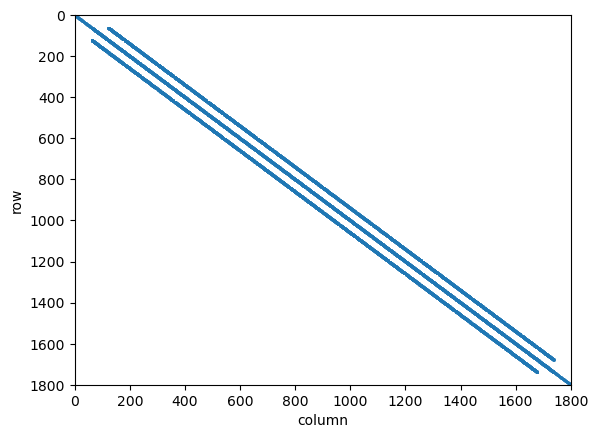

In [4]:
matrix_A_file = 'data/matrix/A.mtx'

def read_mtx(filename):
    with open(filename, 'r') as f:
        # skip comments and header
        for line in f:
            line = line.strip()
            if line == '' or line.startswith('%'):
                continue
            # first non-comment line is the shape line
            parts = line.split()
            if len(parts) >= 3:
                m, n, nnz = map(int, parts[:3])
                break
        # read triplets
        rows = []
        cols = []
        vals = []
        for line in f:
            if line.strip() == '' or line.startswith('%'):
                continue
            p = line.split()
            if len(p) < 3:
                continue
            i, j, v = p[0:3]
            rows.append(int(i)-1)   # convert to 0-based
            cols.append(int(j)-1)
            vals.append(float(v))
    return m, n, np.array(rows), np.array(cols), np.array(vals)

m, n, rows, cols, vals = read_mtx(matrix_A_file)
shape = (m, n)

plt.figure()
plt.xlabel('column')
plt.ylabel('row')
plt.scatter(cols, rows, s=1)
print(shape)

plt.xlim(left=0, right=shape[0])
plt.ylim(bottom=0, top=shape[0])
plt.gca().invert_yaxis()

plt.show()

## Visualization of the Calculated Solution

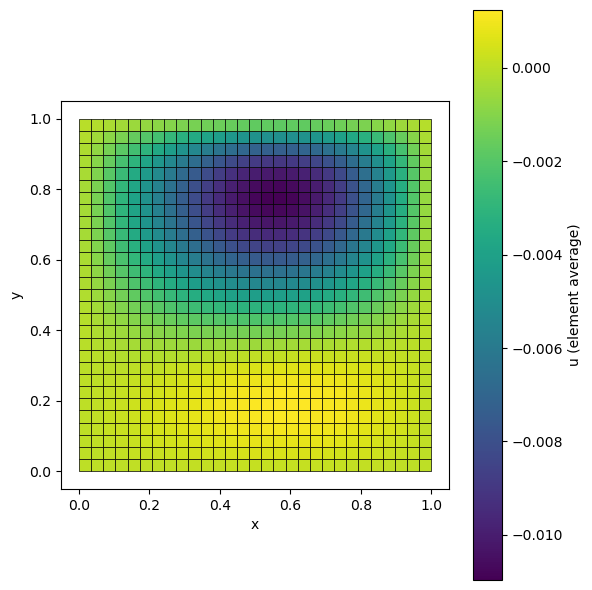

In [6]:
# Define paths to data files
nodes_file = 'data/mesh/nodes.csv'
elems_file = 'data/mesh/elements.csv'
sol_file = 'data/solution/solution.csv'

def read_nodes(fname):
    data = np.loadtxt(fname, delimiter=',', skiprows=1)
    idx = data[:,0].astype(int)
    x = data[:,1]
    y = data[:,2]
    nnode = idx.max()
    X = np.empty(nnode+1)
    Y = np.empty(nnode+1)
    X.fill(np.nan); Y.fill(np.nan)
    X[idx] = x
    Y[idx] = y
    return X, Y

def read_elems(fname):
    data = np.loadtxt(fname, delimiter=',', skiprows=1).astype(int)
    # connectivity columns 1..4 (first column is element idx)
    conn = data[:,1:5]
    return conn

def read_solution(fname):
    data = np.loadtxt(fname, delimiter=',', skiprows=1)
    idx = data[:,0].astype(int)
    u = data[:,1]
    nnode = idx.max()
    U = np.empty(nnode+1)
    U.fill(np.nan)
    U[idx] = u
    return U

def plot_solution(nodes_file, elems_file, sol_file, show_nodes, show_nums, cmap_name):
    X, Y = read_nodes(nodes_file)
    conn = read_elems(elems_file)
    U = read_solution(sol_file)

    patches = []
    values = []
    for el in conn:
        coords = [(X[n], Y[n]) for n in el]
        patches.append(Polygon(coords, closed=True))
        # element scalar = average of nodal values (simple)
        val = np.mean([U[n] for n in el])
        values.append(val)

    fig, ax = plt.subplots(figsize=(6,6))
    pc = PatchCollection(patches, cmap=cmap_name, edgecolor='k', linewidths=0.5)
    pc.set_array(np.array(values))
    ax.add_collection(pc)
    cbar = fig.colorbar(pc, ax=ax)
    cbar.set_label('u (element average)')

    # optionally plot nodes
    if show_nodes:
        ax.plot(X[1:], Y[1:], 'o', markersize=4, zorder=10)

    # optionally show node numbers
    if show_nums:
        for i in range(1, X.size):
            ax.text(X[i], Y[i], str(i), fontsize=7, ha='center', va='center')

    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.autoscale()
    plt.tight_layout()
    plt.show()

plot_solution(nodes_file = nodes_file, elems_file = elems_file, sol_file = sol_file, show_nodes=False, show_nums=False, cmap_name='viridis')
